In [82]:
from operator import attrgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [108]:
def system():
    global TIME
    global TIME_STATUS
    if not TIME_STATUS:
        TIME += 1
    TIME_STATUS = False

In [109]:
def sort_jobs(jobs, attribute, reverse=True):
    return sorted(jobs, key=attrgetter(attribute), reverse=reverse)

In [110]:
def next_job(jobs):
    for job in jobs:
        if not job.finished():
            return job

In [173]:
class Scheduler:
    def __init__(self, jobs, attribute, reverse):
        self.jobs = sort_jobs(jobs, attribute, reverse)
        self.curr_jobs = self.jobs.copy()
        self.attribute = attribute
        self.reverse=reverse
    
    def check_jobs(self):
        for job in self.jobs:
            awaken = job.wake()
            if awaken:
                self.add_job(job)
        self.curr_jobs = sort_jobs(self.curr_jobs, self.attribute, self.reverse)
    
    def remove_job(self, job):
        self.curr_jobs.remove(job)
        
    def add_job(self, job):
        self.curr_jobs.insert(-1,job)
        self.curr_jobs = sort_jobs(self.curr_jobs, self.attribute, self.reverse)

In [174]:
class EarliestDeadlineFirst:
    def __init__(self, jobs, attribute, reverse):
        super().__init__(jobs, attribute, reverse) 
    
    def run(self):
        curr_job = self.curr_jobs[0]
        while TIME<CYCLES:
            self.check_jobs()
            if self.curr_jobs:
                curr_job = self.curr_jobs[0]
                job_status = curr_job.run()
                if curr_job.finished():
                    self.remove_job(curr_job)
                if not job_status:
                    lost_deadline = True
                    break
            system()
            self.update_time_to_deadline()
            
    def update_time_to_deadline():
        for job in self.jobs:
            job.time_to_deadline()

In [175]:
class RateMonotonic(Scheduler):
    def __init__(self, jobs, attribute, reverse):
        super().__init__(jobs, attribute, reverse)   
    
    def run(self):
        curr_job = self.curr_jobs[0]
        while TIME<CYCLES:
            self.check_jobs()
            if self.curr_jobs:
                curr_job = self.curr_jobs[0]
                job_status = curr_job.run()
                if curr_job.finished():
                    self.remove_job(curr_job)
                if not job_status:
                    lost_deadline = True
                    break
            system()

In [176]:
class Processor:
    def __init__(self, jobs):
        self.jobs=jobs
    
    def edf(self):
        scheduler = EarliestDeadlineFirst(self.jobs, 'to_deadline', reverse=False) #Menor Tempo
        scheduler.run()
    def rm(self):
        scheduler = RateMonotonic(self.jobs, 'rm_priority', reverse=True) #Maior prioridade 
        scheduler.run()

In [177]:
class Job:
    def __init__(self, duration, period, name, pid ,priority=0):
        self.duration = duration
        self.period = period
        self.priority = priority
        self.rm_priority = 1/period
        self.deadline = period # Considerado Caso Crítico
        self.runtime = 0
        self.ran = []
        self.active = True
        self.name = name # PID
        self.to_deadline = period-TIME
        self.deadlines = []
        self.pid = pid
    
    def wake(self):
        global TIME
        if(TIME % self.period == 0):
            if(not self.active): #Já tinha rodado no ciclo anterior
                print(f'T={TIME} '+'Zerado'+self.name)
                self.runtime=0
                self.active = True
                self.deadline = TIME+self.period
                return True
            return False
        
    def run(self):
        global TIME
        global TIME_STATUS
        if(not self.finished()):
            TIME_STATUS = True
            if self.check_deadline():
                return False
            self.ran.append(TIME)
            print(f'T={TIME} '+'O Rodando!'+self.name)
            self.runtime += 1
            TIME += 1
        return True
    
    def finished(self):
        if self.runtime >= self.duration:
            self.active = False
            # print(f'T={TIME-1} '+'X Finalizado!'+self.name)
            return True
        return False
    
    def check_deadline(self):
        global TIME
        self.deadlines.append(self.deadline)
        if(TIME>self.deadline):
            print('Uma deadline foi perdida!')
            return True
        
    def time_to_deadline(self):
        self.to_deadline = self.period-TIME
        
    def update_priority(self, priority):
        self.priority = priority

In [178]:
CYCLES = 200

In [179]:
TIME = 0
TIME_STATUS = False
job1 = Job(3, 5, " P1",1)
job2 = Job(2, 3, " P2",2)
job3 = Job(7,15, " P3",3)

In [180]:
jobs = [job1, job2]

In [181]:
for job in sort_jobs(jobs,'rm_priority'):
    print(job.rm_priority)

0.3333333333333333
0.2


In [182]:
for job in sort_jobs(jobs,'to_deadline',False):
    print(job.deadline)

3
5


In [183]:
jobs = [job1,job2]

In [184]:
processor = Processor(jobs)

In [185]:
processor.rm()

T=0 O Rodando! P2
T=1 O Rodando! P2
T=2 O Rodando! P1
T=3 Zerado P2


TypeError: Scheduler.add_job() missing 1 required positional argument: 'job'

In [ ]:
jobs

[<__main__.Job at 0x7f89cd059cf0>, <__main__.Job at 0x7f89cd059480>]

In [ ]:
times = []
for job in jobs:
    for value in job.ran:
        times.append(
            dict(
                Job=job.name,
                Inicio=value,
                Fim=value + 1,
                Resource=f"CPU",
                PID = job.pid
            )
        )
    for value in job.deadlines:
        times.append(
            dict(
                Job=job.name,
                Inicio=value,
                Fim=value + 0.3,
                Resource=f"Deadline",
                PID = job.pid
            )
        )

In [186]:
df = pd.DataFrame(times)
df["Delta"] = df["Fim"] - df["Inicio"]
df.sort_values(by="Inicio", inplace=True)

In [187]:
id

<function id(obj, /)>

In [188]:
df

,Job,Inicio,Fim,Resource,PID,Delta
62,P2,0,1.0,CPU,2,1.0
63,P2,1,2.0,CPU,2,1.0
64,P2,2,3.0,CPU,2,1.0
65,P2,3,4.0,CPU,2,1.0
66,P2,4,5.0,CPU,2,1.0
...,...,...,...,...,...,...
276,P2,210,210.3,Deadline,2,0.3
277,P2,210,210.3,Deadline,2,0.3
278,P2,210,210.3,Deadline,2,0.3
280,P2,210,210.3,Deadline,2,0.3


In [189]:
def process_fig(df, processes, name):
    fig, axis = plt.subplots(figsize=(30, len(processes) * 4))

    axis.set_ylim(9, 10 * (len(processes) + 1))
    axis.set_xlim(0, df["Fim"].max() + 1)

    axis.set_xlabel("Tempo", fontsize=16)
    axis.set_ylabel("Tarefa", fontsize=16)

    print(np.arange(15, 15 * len(processes), 10))
    axis.set_yticks(np.arange(15, 15 * len(processes), 10))
    axis.set_yticklabels([p.name for i, p in enumerate(processes)], fontsize=14)

    axis.grid(True)
    for i, value in enumerate(df.values):
        if value[3] == "CPU":
            axis.broken_barh(
                [(value[1], value[5])],
                ((10 * value[4]+2.5), 5),
                facecolors=("tab:green"),
                label="CPU",
            )
        elif value[3] == "Deadline":
            axis.broken_barh(
                [(value[1], -value[5]/2)],
                (10 * value[4]+2.5, 7),
                facecolors=("black"),
                label="Deadline",
            )
    start, end = axis.get_xlim()
    axis.xaxis.set_ticks(np.arange(start, end, 5))
    axis.set_xticklabels(np.arange(start, end, 5, dtype=int), fontsize=14)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=12, framealpha=0.3)
    plt.tight_layout()
    # plt.savefig(f"{name}.jpeg", dpi=300)

[15 25]


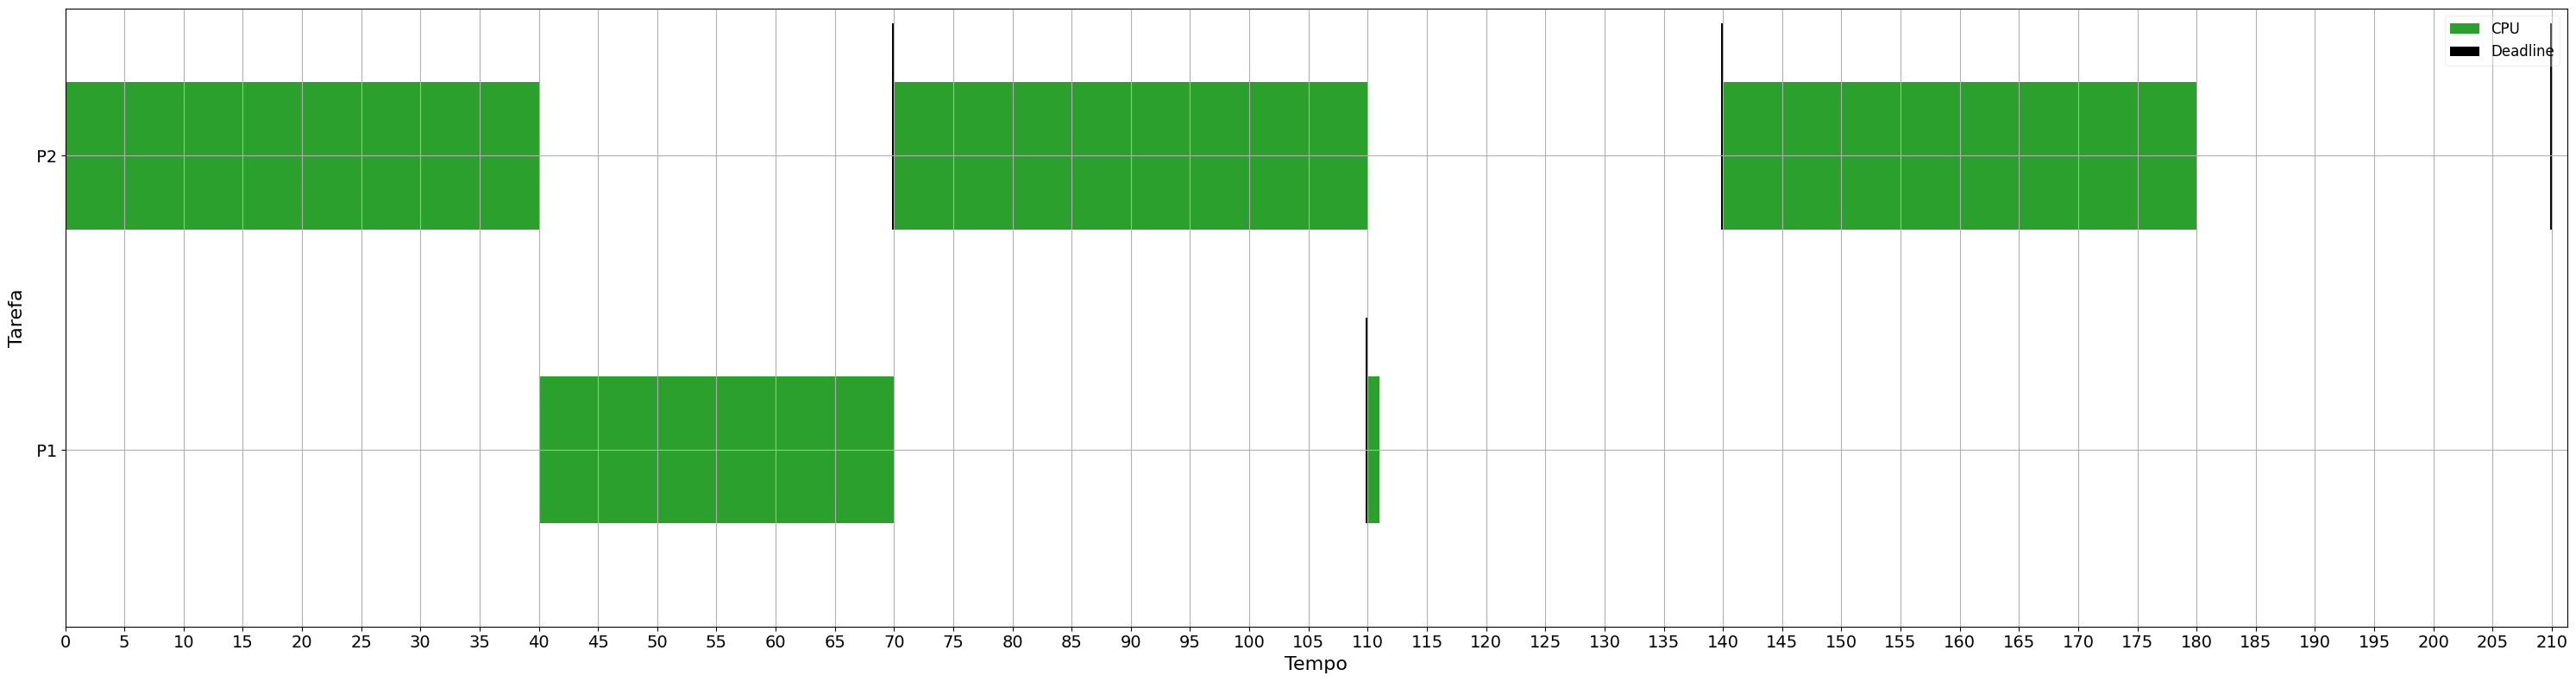

In [190]:
process_fig(df, jobs, 'T')